**Εθνικό Μετσόβιο Πολυτεχνείο**

**Σχολή ΗΜΜΥ**

*Επίδοση Υπολογιστικών Συστημάτων - Σειρά 2*

Αρκαδοπούλου Ελευθερία - el19442

Κονταλέξη Μαρίνα - el18022

**Libraries**

In [19]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy import stats

Η υλοποίηση της προσομοίωσης έχει γίνει με χρήση των παρακάτω κλάσεων.

**Job class**

Συμβολίζει τον πελάτη και περιέχει πληροφορίες σχετικά με την current visit

In [20]:
class Job:                  # επίσκεψη-πελατης
    def __init__(self, id, time, d1, d2):
        self.time = time
        self.d1 = d1
        self.d2 = d2
        self.curr_station = 0
        self.id = str(id)

    def settime(self, time):
        self.startTime = time

    def setentrytime(self, time):
        self.entry = time

    def setrequest(self, r):
        self.request = r

    def setstop(self, s):
        self.stopevent = s

    def print_j(self):
        print("\n\tClient " + self.id + " arrived at " + str(self.time) +
              " is at station " + str(self.curr_station) +
              " remaning visits " + str(self.d1) + " " + str(self.d2) + "\n")

**Event class**

In [21]:
class Event:
    def __init__(self, time, type, job:Job):
        self.time = time
        self.type = type
        self.job = job

    def settime(self, t):
        self.time = t

    def print_ev(self):
        print(self.type + " event happens at " + str(self.time))
        self.job.print_j()

**Station class**

Για κάθε σταθμό

In [22]:
class Station:
    def __init__(self, id, meanService) :
        self.id = id
        self.meanService = meanService
        self.length = 0   # αριθμός εργασιών στον σταθμό
        self.oldClock = -1 # χρονική στιγμή τελευταίου γεγονότος στον σταθμό
        self.uptime = 0
        self.service_time = []

    def print_s(self, ev):
        print("Station " + str(self.id) + " handles:")
        ev.print_ev()

**Disk subclass of station**

In [23]:
class Disk(Station):
    def __init__(self, id, meanService):
        self.jobs = []
        super().__init__(id, meanService)

    def handler(self, ev:Event):
        # self.print_s(ev)
        global events, clock, l, numberClients, numberClientsLeft, stops, d, dep
        job = ev.job
        if ev.type == "arrival":
            request = self.get_service_time()
            job.setrequest(request)
            self.jobs.append(job)
            self.length += 1
            job.setentrytime(clock)
            if self.length == 1:
                job.settime(clock)
                if job.curr_station != self.id:
                    d[job.id] = str(self.id) + " runs " + str(job.curr_station) + d[job.id]
                events.append(Event(clock + request, "departure_d", job))

        if ev.type == "departure_d" or ev.type == "departure_c":
            if ev.type == "departure_c": d[job.id] = "cpu to disk! " + d[job.id]
            self.service_time.append(clock - job.entry)
            self.uptime += (clock - job.startTime)
            curr = self.jobs.pop(0)
            self.length -= 1
            if self.id == 1: curr.d1 -= 1
            elif self.id == 2: curr.d2 -= 1
            curr.curr_station = 0
            events.append(Event(clock, "return", curr))
            if self.length > 0:
                j = self.jobs[0]
                j.settime(clock)
                if j.curr_station != self.id:
                    d[job.id] = str(self.id) + " runs " + str(job.curr_station) + d[job.id]
                events.append(Event(clock + j.request, "departure_d", j))

        if ev.type == "stop":
            d[job.id] = d[job.id] + "->stop_d"
            numberClientsLeft += 1
            stops.append(numberClientsLeft)
            if self.jobs[0] == ev.job:
                self.uptime += (clock - job.startTime)
                curr = self.jobs.pop(0)
                self.length -= 1
                if self.length > 0:
                    j = self.jobs[0]
                    j.settime(clock)
                    if j.curr_station != self.id:
                        d[job.id] = str(self.id) + " runs " + str(job.curr_station) + d[job.id]
                    events.append(Event(clock + j.request, "departure_d", j))
            elif ev.job in self.jobs:
                self.jobs.remove(ev.job)
                self.length -= 1

            for e in events:
                if e.job == job: events.remove(e)

    def get_service_time(self):
        return random.expovariate(1/self.meanService)

**CPU subclass of station**

Στην κλάση CPU συμβαίνει για λόγους ευκολίας και η γέννηση νέων πελατών

In [24]:
class CPU(Station):
    def __init__(self, id, meanService):
        self.last = 0
        self.downtime = 0
        self.client_time = []
        super().__init__(id, meanService)

    def handler (self, ev:Event):
        # self.print_s(ev)
        global events, clock, l, numberClients, numberClientsLeft, rest, stops, d, dep, stations, endCycle
        job = ev.job

        if ev.type == "arrival":
            if self.length + stations[1].length + stations[2].length == 0 and len(self.client_time) >= 10:
                endCycle = True
            if job.id not in d: d[job.id] = "arrival"
            else: d[job.id] = "arr->arr"
            numberClients += 1
            self.newclient()

        if ev.type == "arrival" or ev.type == "return":
            self.length += 1
            request = self.get_service_time()
            job.setrequest(request)
            job.settime(clock)
            # update times for all events
            for e in events:
                j = e.job
                if j.curr_station == self.id and e.type == "end":
                    timeleft = e.time - clock
                    updated = timeleft*self.length/(self.length - 1)
                    e.settime(clock + updated)
            endev = Event(clock + request, "end", job)
            events.append(endev)
            if self.length == 1:
                self.downtime += (clock - self.last)
                return

        if ev.type == "end":
            self.length -= 1
            self.service_time.append(clock-job.startTime)
            self.last = clock
            # routing to d1 or d2
            if job.d1 == 0 and job.d2 == 0:
                if job.id in dep: dep[job.id] += 1
                else: dep[job.id] = 1
                events.append(Event(clock + random.expovariate(1/0.416), "departure_c", job))
            elif job.d1 == 0:
                job.curr_station = 2
                events.append(Event(clock, "arrival", job))
            elif job.d2 == 0:
                job.curr_station = 1
                events.append(Event(clock, "arrival", job))
            else:
                job.curr_station = random.choice([1, 2])
                events.append(Event(clock, "arrival", job))

            # update timeleft for all events
            for e in events:
                j = e.job
                if j.curr_station == self.id and e.type == "end":
                    timeleft = e.time - clock
                    updated = timeleft*(self.length)/(self.length+1)
                    e.settime(clock + updated)

        if ev.type == "departure_c" or ev.type == "departure_d":
            if ev.type == "departure_d": d[job.id] = "disk to cpu! " + d[job.id]
            self.client_time.append(clock-job.time)
            stops.append(numberClientsLeft)
            rest += 1
            d[job.id] = d[job.id] + "->dep_c"
            if job.stopevent in events: events.remove(job.stopevent)
            else: d[job.id] = d[job.id] + " nostopevent"

        if ev.type == "stop":
            if job.id not in dep:
                self.length -= 1
            d[job.id] = d[job.id] + "->stop_c"
            numberClientsLeft += 1
            stops.append(numberClientsLeft)
            for e in events:
                j = e.job
                if j == job: events.remove(e)
                elif j.curr_station == self.id and e.type == "end":
                    timeleft = e.time - clock
                    updated = timeleft*self.length/(self.length + 1)
                    e.settime(clock + updated)

    def get_service_time (self):
        return random.expovariate(1/self.meanService)*self.length

    def newclient(self):
        global clock, numberClients
        t = clock + random.expovariate(l)
        d1 = int(random.expovariate(1/19))
        d2 = int(random.expovariate(1/12))
        maxtime = random.weibullvariate(30, 1.5)
        newjob = Job(numberClients, t, d1, d2)
        s = Event(t + maxtime, "stop", newjob)
        newjob.setstop(s)
        events.append(Event(t, "arrival", newjob))
        events.append(s)

**Confidence interval calculator**

In [25]:
def conf_calc(d, n):
    global z
    y_mean = np.mean([x[0] for x in d])
    c_mean = np.mean([x[1] for x in d])
    R = y_mean/c_mean
    sy2 = 1/(numberCycles-1)*sum((x[0]-y_mean)*(x[0]-y_mean) for x in d)
    sc2 = 1/(numberCycles-1)*sum((x[1]-c_mean)*(x[1]-c_mean) for x in d)
    syc = 1/(numberCycles-1)*sum((x[0]-y_mean)*(x[1]-c_mean) for x in d)
    s = math.sqrt(sy2 -2*R*syc + R*R*sc2)
    margin_of_error = z * s / (c_mean*np.sqrt(n))
    # Calculate the confidence interval
    lower_bound = R - margin_of_error
    upper_bound = R + margin_of_error
    return (lower_bound, R, upper_bound)

**Initialization**

In [26]:
clock = 0
events = []
stops = []
numberClients = nC = 0
nCL = numberClientsLeft = 0
r = rest = 0
l = 1.65        # arrival rate λ
cpu = CPU(0, 0.018)
D1 = Disk(1, 0.028)
D2 = Disk(2, 0.034)
stations = [cpu, D1, D2]
cpu.newclient()     # initial client

# debug dictionaries
d = {}
dep = {}

# cycle information
numberCycles = timeCycleStarted = cycleLength = 0
endCycle = False

# a = 0.95 using normal distribution
z = 1.96

# statistic information
stime = []
perc = []
perc_h = 0
u0 = []
u0_h = 0
u1 = []
u1_h = 0
u2 = []
u2_h = 0

**Program**

Όπως αναφέρεται, η εκτέλεση του προγράμματος σταματά σε 2 περιπτώσεις:

α) όταν το διάστημα εμπιστοσύνης για τον μέσο χρόνο απόκρισης έχει μήκος μικρότερο από το 5% της μέσης τιμής (κατά δικιά μας παραδοχή, έναντι του 10% της εκφώνησης, καθώς για την τιμή 10% το πλήθος των εκτελούμενων αναγεννητικών κύκλων ήταν πολύ μικρό) ή
β) όταν εκτελεστούν 1000 αναγεννητικοί κύκλοι.

Ο λόγος που σταματάει το πρόγραμμα τυπώνεται, όπως τυπώνονται και οι ζητούμενοι δείκτες επίδοσης.

Stopped because confidence interval is less than 5% of average. Νumber of cycles:  300
Average service time: 5.786
Percentage of clients exiting early: 9.684%
CPU utilization: 0.817
Disk1 utilization: 0.740
Disk2 utilization: 0.585
Number of cycles:  300
Below one can find certain graphs that may help with understanding model's behavior


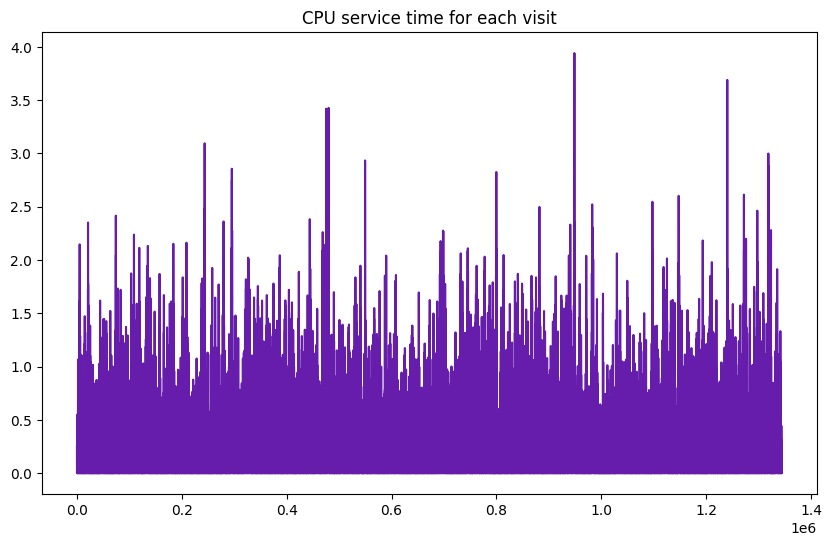

*************************************************************************************************************


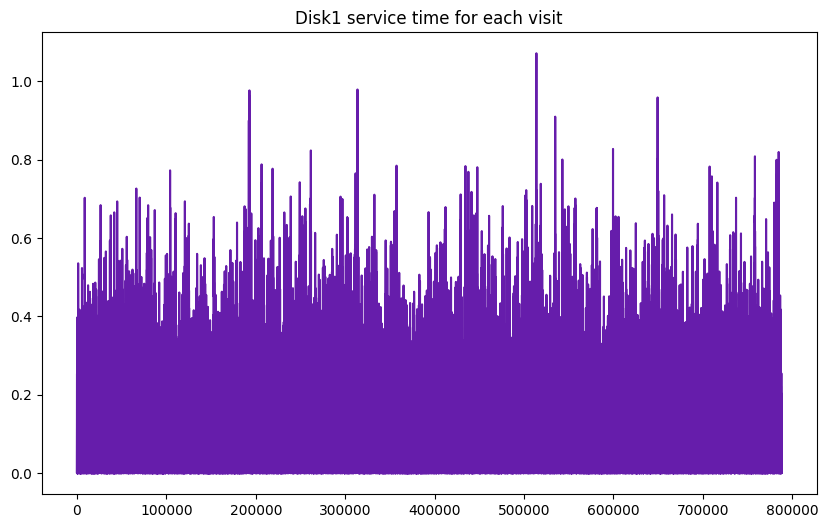

*************************************************************************************************************


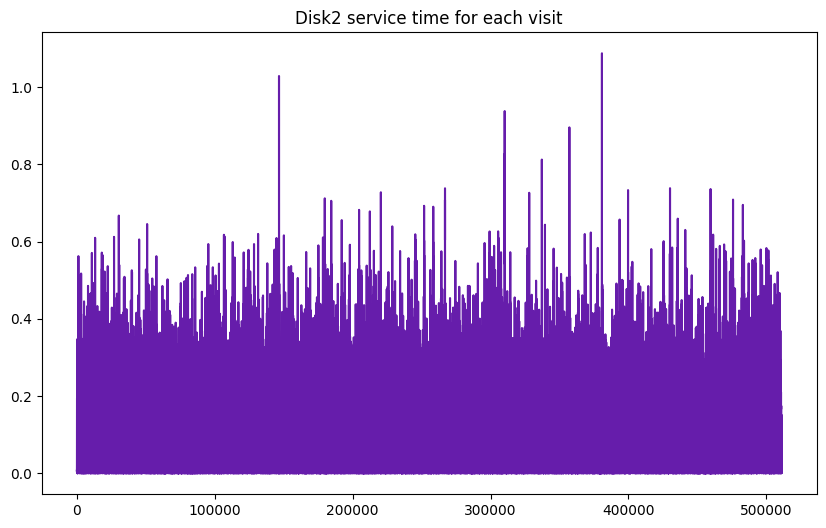

*************************************************************************************************************


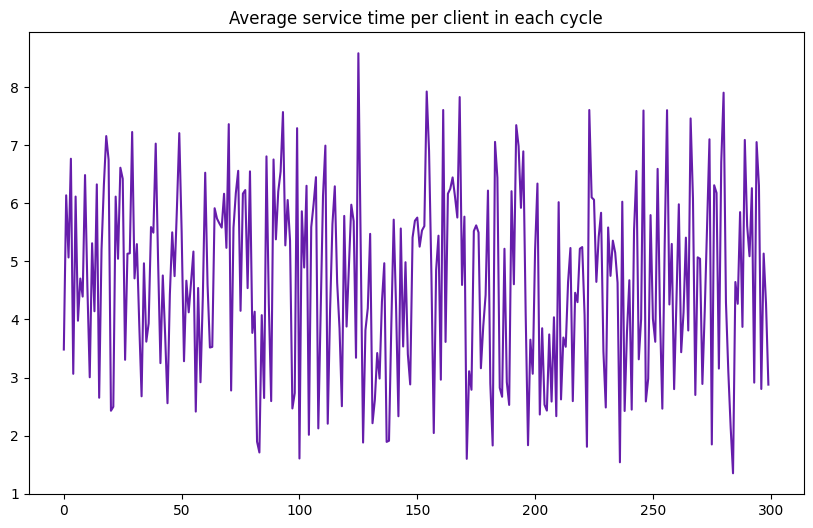

*************************************************************************************************************


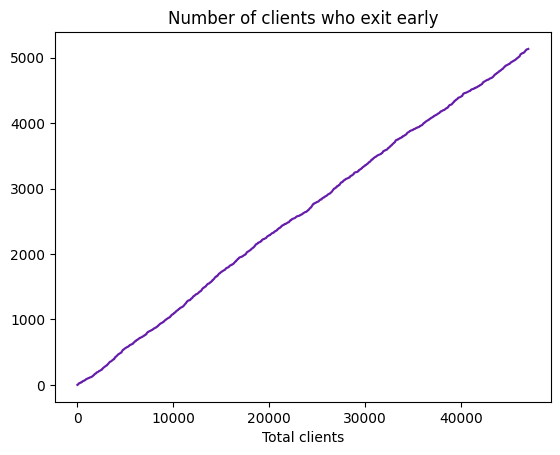

In [27]:
while numberCycles < 1000:
    curr = events.pop(events.index(min(events, key=lambda x: x.time)))
    timepassed = curr.time - clock
    clock = curr.time
    i = curr.job.curr_station
    stations[i].handler(curr)
    if numberClientsLeft > nCL:
        perc_h += (numberClientsLeft-nCL)/(numberClientsLeft-nCL + rest-r)*100*timepassed
    clock_h = clock - timeCycleStarted
    if clock_h != 0:
        u0_h += (clock_h - cpu.downtime)/clock_h*timepassed
        u1_h += D1.uptime/clock_h*timepassed
        u2_h += D2.uptime/clock_h*timepassed
    if endCycle == True:
        cycleLength = clock - timeCycleStarted
        endCycle = False
        numberCycles += 1
        stime.append((sum(cpu.client_time), len(cpu.client_time)))
        cpu.client_time = []
        perc.append((perc_h, cycleLength))
        perc_h = 0
        nCL = numberClientsLeft
        r = rest
        nC = numberClients
        u0.append((u0_h, cycleLength))
        cpu.downtime = 0
        u0_h = 0
        u1.append((u1_h, cycleLength))
        D1.uptime = 0
        u1_h = 0
        u2.append((u2_h, cycleLength))
        D2.uptime = 0
        u2_h = 0
        timeCycleStarted = clock
        if (numberCycles % 20 == 0): #κάθε 20 αναγεννητικούς κύκλους
            (lower, s_avg, upper) = conf_calc(stime, numberCycles)
            #if numberCycles == 1000 or (upper-lower) <= 0.1*s_avg:
            if numberCycles == 1000 or (upper-lower) <= 0.05*s_avg:
                if numberCycles == 1000: print("Stopped due to reaching 1000 cycles")
                else: print("Stopped because confidence interval is less than 5% of average. Νumber of cycles: ", numberCycles)
                print("Average service time: {:.3f}".format(s_avg))
                res = []
                data = [perc, u0, u1, u2]
                for d in data:
                    (lo, avg, up) = conf_calc(d, numberCycles)
                    res.append(avg)
                print("Percentage of clients exiting early: {:.3f}%".format(res[0]))
                print("CPU utilization: {:.3f}".format(res[1]))
                print("Disk1 utilization: {:.3f}".format(res[2]))
                print("Disk2 utilization: {:.3f}".format(res[3]))
                print("Number of cycles: ", numberCycles)
                #print("Confidence Interval", lower, s_avg, upper)
                print("Below one can find certain graphs that may help with understanding model's behavior")
                break

plt.figure(figsize=(10, 6))
plt.plot(cpu.service_time, color='#661DAB')
plt.title("CPU service time for each visit")
plt.show()
print("*************************************************************************************************************")
plt.figure(figsize=(10, 6))
plt.plot(D1.service_time, color='#661DAB')
plt.title("Disk1 service time for each visit")
plt.show()
print("*************************************************************************************************************")
plt.figure(figsize=(10, 6))
plt.plot(D2.service_time, color='#661DAB')
plt.title("Disk2 service time for each visit")
plt.show()
print("*************************************************************************************************************")
plt.figure(figsize=(10, 6))
plt.plot([x[0]/x[1] for x in stime], color='#661DAB')
plt.title("Average service time per client in each cycle")
plt.show()
print("*************************************************************************************************************")
plt.plot(stops, color='#661DAB')
plt.title("Number of clients who exit early")
plt.xlabel("Total clients")
plt.show()